### HW2 for Fixed-income Quantitative Trading

** Xingyue Huang (N14034682) **
* Please note that the hw are coded under Python 2 environment
* And system may suggest the use of 'loc' instead of 'iloc' via Warnings repeatedly, yet codes are running smoothly without errors
* Also, the result summaries and package methodologies are given right above/below relevant code sections, not the bottom of the whole codes.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.tsa.stattools as tsa
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA

# read CMT file and perform pre data processing
data_raw = pd.read_excel('CMT-all.xlsx')
data_raw.set_index('Date', inplace=True)
data = data_raw[['3M', '2Y', '5Y', '7Y', '10Y', '30Y']]
print data.head() # display the first five rows of the data

sample1 = data.loc['2013-01-02':'2015-01-02',:]
sample2 = data.loc['2015-01-02':'2017-01-03',:]
assert ~sample1.isnull().values.any(), 'Warning: Sample1 still has NaN values.'
assert ~sample2.isnull().values.any(), 'Warning: Sample2 still has NaN values.'

              3M    2Y    5Y    7Y   10Y   30Y
Date                                          
1990-01-02  7.83  7.87  7.87  7.98  7.94  8.00
1990-01-03  7.89  7.94  7.92  8.04  7.99  8.04
1990-01-04  7.84  7.92  7.91  8.02  7.98  8.04
1990-01-05  7.79  7.90  7.92  8.03  7.99  8.06
1990-01-08  7.79  7.90  7.92  8.05  8.02  8.09


#### On PCA
Here I calculated PCA myself instead of turning to packages. 

The basic idea of PCA is to find the eigenvactors whose corresponding eigenvalues are among the biggest from covariance matrix.

First I calculated the covariance matrix of sample1 and then found its eigenvalues and eigenvectors. Next, sort the eigen pairs by eigenvalues in a decreasing order.

The first three components are displayed and plotted.

First threee components: 
[[ 0.01606211 -0.04460093  0.06446293]
 [-0.08776953  0.31442274  0.90645103]
 [-0.4953976   0.49579408 -0.01405667]
 [-0.57822718  0.21552659 -0.26373036]
 [-0.52447867 -0.23546608 -0.06869714]
 [-0.37039868 -0.74259096  0.31578548]] 



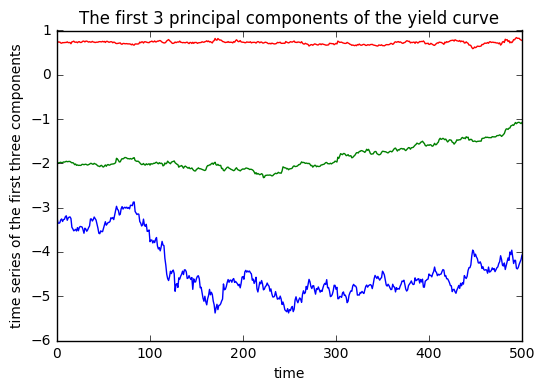

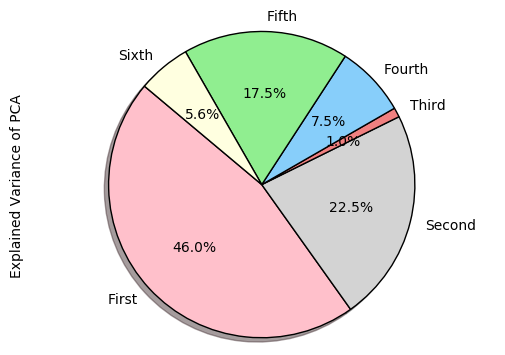

In [2]:
# perform PCA on sample1 for rates
cov_1 = sample1.cov() # calculate the covariance matrix of sample1 based on returnsprint(cov_1)
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_1) # calculate eigenvalues and eigenvectors of cov_1
for ev in eig_vec_cov: # assert the correctness of calculation
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))# make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
eig_pairs.sort(key=lambda x: x[0], reverse=True) # sort the (eigenvalue, eigenvector) tuples from high to low

matrix_w = np.hstack((eig_pairs[0][1].reshape(6,1), eig_pairs[1][1].reshape(6,1), eig_pairs[2][1].reshape(6,1)))
print 'First threee components: \n', matrix_w, '\n'

# plot time series of the first 3 principal components
ts_3c = np.dot(sample1.iloc[:,:6].values, matrix_w)
plt.plot(ts_3c)
plt.xlabel('time')
plt.ylabel('time series of the first three components')
plt.title('The first 3 principal components of the yield curve')
plt.show()

# display and plot explained variances of PCA
var_list = []
for i in range(6):
    var_list.append(np.var(np.dot(sample1.iloc[:,:6].values, eig_vec_cov[i].reshape(6,1))))
var_agg = sum(var_list)
var_pct = [item / var_agg for item in var_list]

colors = ['pink', 'lightgrey', 'lightcoral', 'lightskyblue', 'lightgreen', 'lightyellow']
labels = 'First', 'Second', 'Third', 'Fourth', 'Fifth', 'Sixth'
plt.pie(var_pct, autopct='%1.1f%%', colors=colors, labels = labels, shadow=True, startangle=140)
plt.axis('equal')
plt.ylabel('Explained Variance of PCA')
plt.show()

In [3]:
# calculate FLY(2y-5y+10y) for sample1 & sample2
sample1.loc[:, 'FLY'] = sample1.loc[:, '2Y'] - sample1.loc[:, '5Y'] + sample1.loc[:, '10Y']
sample2.loc[:, 'FLY'] = sample2.loc[:, '2Y'] - sample2.loc[:, '5Y'] + sample2.loc[:, '10Y']

# find weights for PCA FLY
eig_vec_1 = eig_pairs[0][1]
eig_vec_2 = eig_pairs[1][1]
a = np.array([[eig_vec_1[2]], [eig_vec_2[2]]])
b = np.linalg.inv(np.array([[eig_vec_1[1], eig_vec_1[4]], [eig_vec_2[1], eig_vec_2[4]]]))
w1, w2 = np.dot(b, a)[0][0], np.dot(b, a)[1][0]

# calculate PCA FLY(2y-5y+10y) for sample1 & sample2
sample1.loc[:, 'PCA FLY'] = sample1.loc[:, '2Y'] * w1 - sample1.loc[:, '5Y'] + sample1.loc[:, '10Y'] * w2
sample2.loc[:, 'PCA FLY'] = sample2.loc[:, '2Y'] * w1 - sample2.loc[:, '5Y'] + sample2.loc[:, '10Y'] * w2

/Users/huangxingyue/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/huangxingyue/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:561: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


#### On ADF tests for FLY & PCA FLY on sample1 and sample2
Here I used the package 'statsmodels' to perform ADF test.

ADF test examines whether a time series is stationary via calculating its unit roots. It all the unit roots are outside unit circle, the time series is stationary; otherwise not.

The ordinary FLY on both training and test samples are far from stationary (p-values are above 0.6).

The PCA FLY on training sample(sample1) is stationary (p-value=0.0019 << 0.05), which also demonstrates that the first two components calculated on sample1 are adequately explainatory of sample1. On the other hand, the PCA FLY on test sample is ill-behaved with p-value above 0.84. *This shows the instability of key rates of the yield curve.* 

In [4]:
# compute ADF test statistic for FLY & PCA FLY in sample 1 & sample2, 20 pts
adf_sample1_fly = tsa.adfuller(sample1['FLY'])
print 'adf of sample1_fly: ', adf_sample1_fly[0]
print 'p-value of sample1_fly: ', adf_sample1_fly[1]
print 'critical values of sample1_fly: ', adf_sample1_fly[4], '\n'

adf_sample1_pcafly = tsa.adfuller(sample1['PCA FLY'])
print 'adf of sample1_pcafly: ', adf_sample1_pcafly[0] 
print 'p-value of sample1_pcafly: ', adf_sample1_pcafly[1]
print 'critical values of sample1_pcafly: ', adf_sample1_pcafly[4], '\n'

adf_sample2_fly = tsa.adfuller(sample2['FLY'])
print 'adf of sample2_fly: ', adf_sample2_fly[0]
print 'p-value of sample2_fly: ', adf_sample2_fly[1]
print 'critical values of sample2_fly: ', adf_sample2_fly[4], '\n'

adf_sample2_pcafly = tsa.adfuller(sample2['PCA FLY'])
print 'adf of sample2_pcafly: ', adf_sample2_pcafly[0]
print 'p-value of sample2_pcafly: ', adf_sample2_pcafly[1]
print 'critical values of sample2_pcafly: ', adf_sample2_pcafly[4], '\n'

adf of sample1_fly:  -1.16649887314
p-value of sample1_fly:  0.687838541778
critical values of sample1_fly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample1_pcafly:  -3.91297949627
p-value of sample1_pcafly:  0.00194137470087
critical values of sample1_pcafly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample2_fly:  -1.12848719691
p-value of sample2_fly:  0.703578899213
critical values of sample2_fly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample2_pcafly:  -0.739523497801
p-value of sample2_pcafly:  0.83624479094
critical values of sample2_pcafly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 



#### On CCA - Box & Tiao (1977)
Here I performed CCA according to Box & Tiao (1977).

It finds linear combinations of variables ranked in order of predictability by computing eigenvectors of Q (the matrix measure of predictibility). The compnents/eigenvectors corresponding to larger eigenvalues have better predictibility while those corresponding to smaller eigenvalues have worse and thus depend less on the past, which means more stationary.

Then I tried to build COINT FLY using weights calculated by two eigenvectors corresponding to least eigenvalues and performed ADF test on it. We can see from the output below that the COINT FLY built this way is way far from stationary, thus Box & Tiao method for cointegration is not good in this case.

In [5]:
# perform cointegration analysis either by Box-Tiao or Chou-Ng in Sample1, 20 pts
X = sample1.iloc[:-1,:6]
Y = sample1.iloc[1:,:6] # Y is the first-order lag of X
A = np.linalg.lstsq(X,Y)[0] # least square solution to Y = X*A
C = cov_1 # covariance matrix of X/Y
Q = np.dot(np.linalg.inv(C),np.dot(A, np.dot(C, A.T))) # measure of relative predictibility according to Box & Tiao
eig_val_cov, eig_vec_cov = np.linalg.eig(Q) # calculate eigenvalues and eigenvectors of Q
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:,i]) for i in range(len(eig_val_cov))]
eig_pairs.sort(key=lambda x: x[0], reverse=False) # sort the (eigenvalue, eigenvector) tuples from low to high
print 'least-square solution to Y = X*A: \n', A, '\n'
print 'measure of relative predictibility Q: \n', Q, '\n'
print 'eig_pairs of Q sorted by eigenvalues: \n', eig_pairs, '\n'
print 'eigen_values of Q: \n', eig_val_cov, '\n'
print 'factor loadings: \n', eig_vec_cov, '\n'

least-square solution to Y = X*A: 
[[  8.05288437e-01   3.02292819e-02  -4.20364269e-02  -3.98574526e-03
   -5.25790336e-02  -3.00464770e-02]
 [  3.43165250e-02   8.84293402e-01  -1.22942219e-01  -1.72701176e-01
   -1.37280989e-01  -1.17607998e-01]
 [ -1.18625464e-01   2.58869928e-02   9.24320247e-01   1.02604003e-01
    1.43419388e-06   8.55339444e-02]
 [  1.58795304e-01   1.41934280e-01   3.28426601e-01   1.06502616e+00
    2.01368013e-01  -8.72419646e-03]
 [ -9.02709702e-02  -2.16559682e-01  -3.66286099e-01  -2.19440721e-01
    7.11394870e-01  -1.00634728e-01]
 [  2.20577726e-02   7.70760511e-02   1.22451010e-01   9.84015291e-02
    1.09191619e-01   1.05553127e+00]] 

measure of relative predictibility Q: 
[[   24.8148985     57.17653925  -196.12129957  -306.72436436
      8.01342931  -169.05058685]
 [   -8.41780579   -13.24264715    75.04379903   112.39398151
    -10.03433488    45.19625866]
 [   73.49542082   161.83199251  -607.59005528  -941.8432553     38.01207616
   -486.375205

In [6]:
# find weights for COINT FLY
eig_vec_1 = eig_pairs[0][1]
eig_vec_2 = eig_pairs[1][1]
a = np.array([[eig_vec_1[2]], [eig_vec_2[2]]])
b = np.linalg.inv(np.array([[eig_vec_1[1], eig_vec_1[4]], [eig_vec_2[1], eig_vec_2[4]]]))
w3, w4 = np.dot(b, a)[0][0], np.dot(b, a)[1][0]

# calculate COINT FLY
sample1.loc[:,'COINT FLY'] = sample1.loc[:, '2Y'] * w3 - sample1.loc[:, '5Y'] + sample1.loc[:, '10Y'] * w4
sample2.loc[:,'COINT FLY'] = sample2.loc[:, '2Y'] * w3 - sample2.loc[:, '5Y'] + sample2.loc[:, '10Y'] * w4

# perform ADF test on COINT FLY in sample1&2
adf_sample1_cointfly = tsa.adfuller(sample1['COINT FLY'])
print 'adf of sample1_cointfly: ', adf_sample1_cointfly[0]
print 'p-value of sample1_cointfly: ', adf_sample1_cointfly[1]
print 'critical values of sample1_cointfly: ', adf_sample1_cointfly[4], '\n'

adf_sample2_cointfly = tsa.adfuller(sample2['COINT FLY'])
print 'adf of sample1_pcafly: ', adf_sample2_cointfly[0] 
print 'p-value of sample1_pcafly: ', adf_sample2_cointfly[1]
print 'critical values of sample1_pcafly: ', adf_sample2_cointfly[4]

adf of sample1_cointfly:  0.446681107828
p-value of sample1_cointfly:  0.983159172567
critical values of sample1_cointfly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample1_pcafly:  -1.03457304326
p-value of sample1_pcafly:  0.74044670724
critical values of sample1_pcafly:  {'5%': -2.8673378563200003, '1%': -3.4434963794639999, '10%': -2.5698580359999998}


#### Use level regression to find COINT FLY
Here I used the package 'sckit-learn' to perform linear regression on level rates and find weights for COINT FLY.

The basic idea for linear regression is to find the coefficient for independent variables that can best explain dependent variables under least squares or maximum likelihood.

The coefficients here are weights for COINT FLY because if 2Y, 5Y, 10Y have cointegration relationship, there must exist a stationary linear combination of the three, which is exactly the residue of linear regression best modelled.

In [7]:
# calculate COINT FLY for sample1 & sample2, 5 pts
lr = LinearRegression()
lr.fit(sample1[['2Y','10Y']], sample1['5Y'])
w3_, w4_ = lr.coef_ # find weights for COINT FLY via level regression
sample1.loc[:,'COINT FLY'] = sample1.loc[:, '2Y'] * w3_ - sample1.loc[:, '5Y'] + sample1.loc[:, '10Y'] * w4_
sample2.loc[:,'COINT FLY'] = sample2.loc[:, '2Y'] * w3_ - sample2.loc[:, '5Y'] + sample2.loc[:, '10Y'] * w4_

#### On ADF tests for COINT FLY on sample1 and sample2
The COINT FLY is also stationary on sample1 with p-value = 0.003 << 0.05 while not on sample2 with p-value = 0.84.

This shows that the linear model is overfitting in training sample and requires some methods to prevent that such as variable reduction, ridge regression/LASSO.

This again proves the instability of key rates of the yield curve.

In [8]:
# compute ADF test statistics for COINT FLY in sample1 & sample2, 10 pts
adf_sample1_cointfly = tsa.adfuller(sample1['COINT FLY'])
print 'adf of sample1_cointfly: ', adf_sample1_cointfly[0]
print 'p-value of sample1_cointfly: ', adf_sample1_cointfly[1]
print 'critical values of sample1_cointfly: ', adf_sample1_cointfly[4], '\n'

adf_sample2_cointfly = tsa.adfuller(sample2['COINT FLY'])
print 'adf of sample1_pcafly: ', adf_sample2_cointfly[0] 
print 'p-value of sample1_pcafly: ', adf_sample2_cointfly[1]
print 'critical values of sample1_pcafly: ', adf_sample2_cointfly[4]

adf of sample1_cointfly:  -3.79207482615
p-value of sample1_cointfly:  0.00298944868216
critical values of sample1_cointfly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056} 

adf of sample1_pcafly:  -0.734984394781
p-value of sample1_pcafly:  0.837478528006
critical values of sample1_pcafly:  {'5%': -2.8673495105661462, '1%': -3.4435228622952065, '10%': -2.569864247011056}
